In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# **1. Load Example Dataset**

We’ll use California Housing dataset (multivariate regression).

In [3]:
from sklearn.datasets import fetch_california_housing

# Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# **2. Data Overview**

In [4]:
df.describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


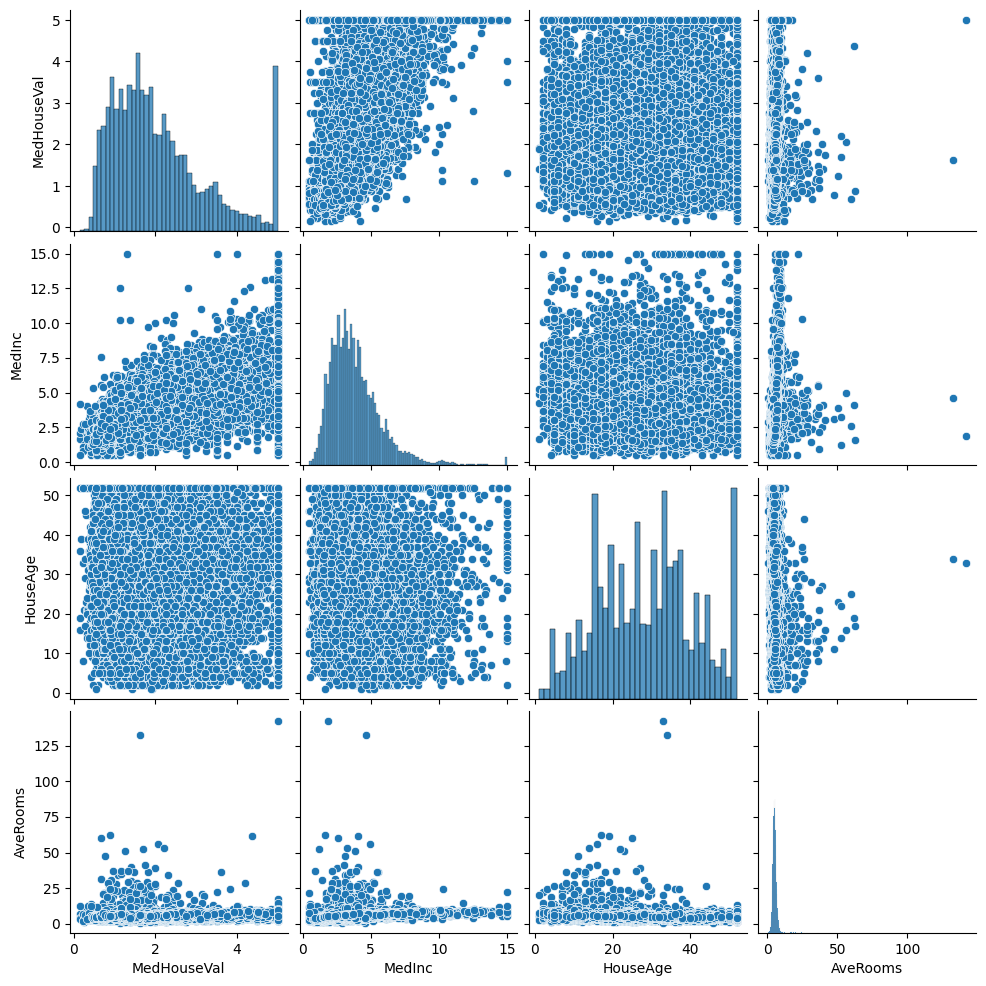

In [5]:
sns.pairplot(df[["MedHouseVal", "MedInc", "HouseAge", "AveRooms"]])
plt.show()


Diagonal plots (histograms):

Show the distribution of each variable individually.

MedHouseVal and MedInc are right-skewed — most houses have lower values and incomes, with a few very high ones.

HouseAge is roughly uniform, meaning houses are evenly spread across different ages.

AveRooms has a few extreme outliers (some houses with abnormally high room counts).

Off-diagonal scatter plots:

Each cell shows how two variables are related.

MedInc vs MedHouseVal: clear positive correlation — higher income areas tend to have higher house values.

HouseAge vs MedHouseVal: almost no correlation — older or newer houses don’t directly affect value.

AveRooms vs MedHouseVal: weak positive relation with some outliers — houses with more rooms can be more valuable, but it’s not consistent.

Other combinations (e.g., HouseAge vs MedInc) show little or no pattern.

# **3. Splitting Data**

In [6]:
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **4. Multicollinearity (VIF)**

**Variance Inflation Factor (VIF)** for a predictor x_i is:
$VIF_i$ = 1 / (1 - $R_i^2$), where $R_i^2$ is from regressing $x_i$ on all OTHER predictors.

- VIF ≈ 1   : no multicollinearity
- VIF 1–5   : mild/acceptable
- VIF > 5   : problematic in many fields
- VIF > 10  : high/severe

High VIF ⇒ inflated standard errors ⇒ unstable coefficients (sign flips, wide CIs),
even when overall R² looks fine.


In [7]:
# VIF(Variance Inflation Factor) requires no constant, so we add one
X_with_const = sm.add_constant(X_train)

vif = pd.DataFrame()
vif["feature"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i)
              for i in range(X_with_const.shape[1])]
vif


,feature,VIF
0,const,16901.024982
1,MedInc,2.539815
2,HouseAge,1.237337
3,AveRooms,7.917240
4,AveBedrms,6.609200
5,Population,1.134824
6,AveOccup,1.009733
7,Latitude,9.206134
8,Longitude,8.875984


VIF > 10 → High multicollinearity (bad).

VIF between 5–10 → Moderate concern.

VIF < 5 → Safe.

"Const" (intercept) always has a huge VIF, so we ignore it.

Most features (MedInc, HouseAge, Population, AveOccup) are safe.

AveRooms & AveBedrms → correlated, because naturally more rooms means more bedrooms.

Latitude & Longitude → highly correlated, since nearby locations usually co-vary.

Example: in California, latitude and longitude are not independent.

**Why this matters?**

If you include both AveRooms and AveBedrms, the model struggles to decide:
“Is the price increasing because of rooms or bedrooms? Both seem to explain the same thing.”

This makes coefficients unstable (signs/sizes can flip if you add/remove variables).

**Solutions**

Drop one of the correlated features (e.g., use AveRooms, drop AveBedrms).

Combine them into a new feature (e.g., Ratio = AveRooms/AveBedrms).

Use PCA (dimensionality reduction).

# **5. Fit MLR Model**

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: -37.02327770606416
Coefficients: [ 4.48674910e-01  9.72425752e-03 -1.23323343e-01  7.83144907e-01
 -2.02962058e-06 -3.52631849e-03 -4.19792487e-01 -4.33708065e-01]


In [9]:
#  Identify high-VIF features
threshold = 5
high_vif = vif[vif["VIF"] > threshold]["feature"].tolist()

print("Features with VIF > 5:", high_vif)


Features with VIF > 5: ['const', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']


In [10]:
#   Drop one high-VIF feature (example: AveBedrms)
X_reduced = X.drop("AveBedrms", axis=1)

# Train-test split again
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Fit reduced model
model_reduced = LinearRegression()
model_reduced.fit(X_train_r, y_train_r)
y_pred_r = model_reduced.predict(X_test_r)

# Evaluation
mae_r = mean_absolute_error(y_test_r, y_pred_r)
mse_r = mean_squared_error(y_test_r, y_pred_r)
rmse_r = np.sqrt(mse_r)
r2_r = r2_score(y_test_r, y_pred_r)

n_r = X_test_r.shape[0]
k_r = X_test_r.shape[1]
adj_r2_r = 1 - (1-r2_r)*(n_r-1)/(n_r-k_r-1)

print("Reduced Model (after dropping AveBedrms)")
print(f"MAE: {mae_r:.3f}")
print(f"MSE: {mse_r:.3f}")
print(f"RMSE: {rmse_r:.3f}")
print(f"R²: {r2_r:.3f}")
print(f"Adjusted R²: {adj_r2_r:.3f}")


Reduced Model (after dropping AveBedrms)
MAE: 0.543
MSE: 0.547
RMSE: 0.740
R²: 0.582
Adjusted R²: 0.582


In [11]:
# Compare coefficients before vs after
coef_full = pd.Series(model.coef_, index=X.columns)
coef_reduced = pd.Series(model_reduced.coef_, index=X_reduced.columns)

print("Full Model Coefficients:")
print(coef_full)

print("\nReduced Model Coefficients:")
print(coef_reduced)


Full Model Coefficients:
MedInc        0.448675
HouseAge      0.009724
AveRooms     -0.123323
AveBedrms     0.783145
Population   -0.000002
AveOccup     -0.003526
Latitude     -0.419792
Longitude    -0.433708
dtype: float64

Reduced Model Coefficients:
MedInc        0.371939
HouseAge      0.009792
AveRooms      0.019116
Population   -0.000003
AveOccup     -0.003237
Latitude     -0.457872
Longitude    -0.464572
dtype: float64


***Full Model (with AveBedrms)***

AveRooms = -0.123 ( negative, counterintuitive — more rooms → lower price??)

AveBedrms = +0.783 (very large positive)
 This weird sign flip is due to multicollinearity → rooms & bedrooms overlap too much.

***Reduced Model (dropped AveBedrms)***

AveRooms = +0.019 (now positive & reasonable: more rooms → slightly higher price)

No AveBedrms column anymore.

Other coefficients (MedInc, Latitude, Longitude) changed slightly but remain stable.

Before dropping: coefficients were unstable and hard to interpret.

After dropping: coefficients became more meaningful (signs make sense).

Adjusted R² didn’t drop much → prediction power is almost the same.

# **6. Model Evaluation**

In [12]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

n = X_test.shape[0]
k = X_test.shape[1]
adj_r2 = 1 - (1-r2)*(n-1)/(n-k-1)
print("Full Model Metrics")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"Adjusted R²: {adj_r2:.3f}")


Full Model Metrics
MAE: 0.533
MSE: 0.556
RMSE: 0.746
R²: 0.576
Adjusted R²: 0.575


# **7. Handling Categorical Variables (Demo)**



In [13]:
df_cat = pd.DataFrame({
    "Size": [1000, 1500, 2000, 2500, 1800],
    "Bedrooms": [2, 3, 3, 4, 2],
    "Location": ["A", "B", "A", "C", "B"],
    "Price": [200000, 250000, 300000, 400000, 280000]
})

# One-hot encoding
df_encoded = pd.get_dummies(df_cat, columns=["Location"], drop_first=True)
df_encoded


,Size,Bedrooms,Price,Location_B,Location_C
0,1000,2,200000,False,False
1,1500,3,250000,True,False
2,2000,3,300000,False,False
3,2500,4,400000,False,True
4,1800,2,280000,True,False


In [14]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [15]:
# ----------------------------
# Demo: Univariate vs Bivariate vs Multivariate Regression
# ----------------------------
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Target
y = df["MedHouseVal"]

# --- 1. Univariate Regression (MedInc only) ---
X_uni = df[["MedInc"]]
model_uni = LinearRegression().fit(X_uni, y)
print("Univariate R² (MedInc only):", model_uni.score(X_uni, y))

# --- 2. Bivariate Regression (MedInc + HouseAge) ---
X_bi = df[["MedInc", "HouseAge"]]
model_bi = LinearRegression().fit(X_bi, y)
print("Bivariate R² (MedInc + HouseAge):", model_bi.score(X_bi, y))

# --- 3. Multivariate Regression (all predictors) ---
X_multi = df.drop(columns=["MedHouseVal"])
model_multi = LinearRegression().fit(X_multi, y)
print("Multivariate R² (All features):", model_multi.score(X_multi, y))



Univariate R² (MedInc only): 0.4734474918071989
Bivariate R² (MedInc + HouseAge): 0.5091195899765226
Multivariate R² (All features): 0.606232685199805


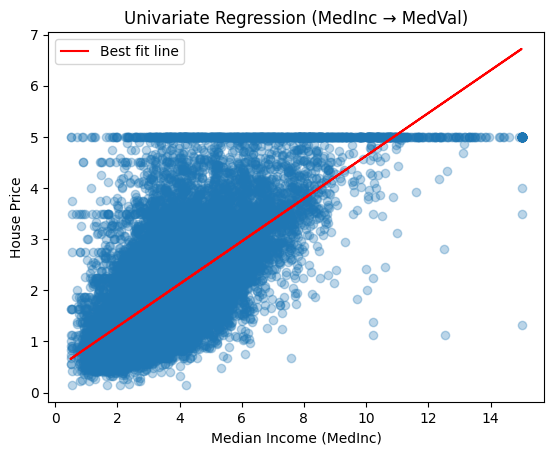

In [16]:
#  Visualization for Univariate (just MedInc vs MedianValue)
plt.scatter(X_uni, y, alpha=0.3)
plt.plot(X_uni, model_uni.predict(X_uni), color='red', label="Best fit line")
plt.xlabel("Median Income (MedInc)")
plt.ylabel("House Price")
plt.title("Univariate Regression (MedInc → MedVal)")
plt.legend()
plt.show()


c:\Users\Raktim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


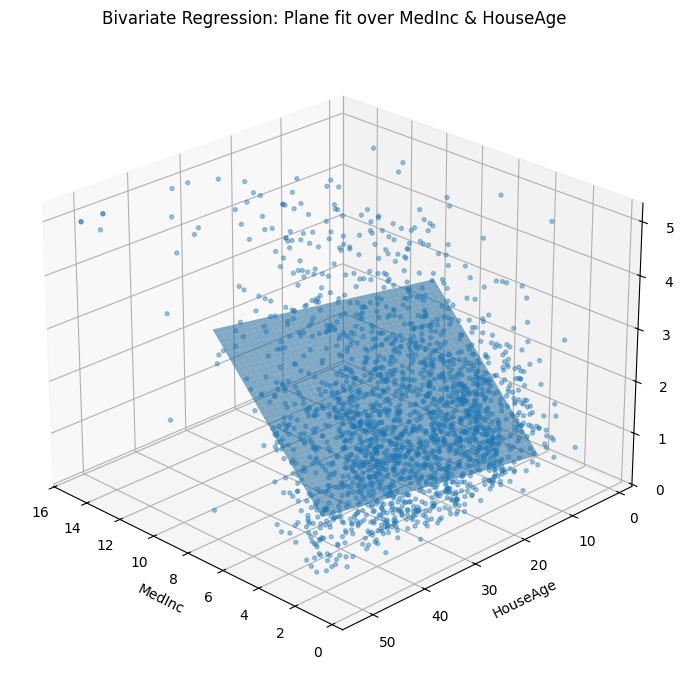

R² (MedInc + HouseAge): 0.5091
Plane equation: y = 0.4317*MedInc + 0.0174*HouseAge + -0.1019


In [17]:
# --- 3D visualization of bivariate regression: MedInc + HouseAge -> MedHouseVal ---
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401; needed for 3D projection
from sklearn.linear_model import LinearRegression

# Subsample (optional) to keep the plot light
df_plot = df.sample(n=min(len(df), 2000), random_state=42).copy()



# Create a grid over the feature space
medinc_lin = np.linspace(np.percentile(df_plot["MedInc"], 5),
                         np.percentile(df_plot["MedInc"], 95), 40)
houseage_lin = np.linspace(np.percentile(df_plot["HouseAge"], 5),
                           np.percentile(df_plot["HouseAge"], 95), 40)
G1, G2 = np.meshgrid(medinc_lin, houseage_lin)
X_grid = np.c_[G1.ravel(), G2.ravel()]
Z = model_bi.predict(X_grid).reshape(G1.shape)

# 3D scatter + plane
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")

# Scatter the actual points
ax.scatter(df_plot["MedInc"], df_plot["HouseAge"], df_plot["MedHouseVal"],
           s=8, alpha=0.4, depthshade=True)

# Plot the regression plane
ax.plot_surface(G1, G2, Z, alpha=0.55, edgecolor="none")


# Labels & view
ax.set_xlabel("MedInc")
ax.set_ylabel("HouseAge")
ax.set_zlabel("MedHouseVal")
ax.set_title("Bivariate Regression: Plane fit over MedInc & HouseAge")
ax.view_init(elev=25, azim=135)

plt.tight_layout()
plt.show()

# Print model fit for reference
print("R² (MedInc + HouseAge):", round(model_bi.score(X_bi, y), 4))
print("Plane equation: y = {:.4f}*MedInc + {:.4f}*HouseAge + {:.4f}"
      .format(model_bi.coef_[0], model_bi.coef_[1], model_bi.intercept_))


Univariate → scatter + regression line

Bivariate → 3D scatter + regression plane

Multivariate → Actual vs Predicted (or Residual plots)

How does Adj_R2 decrease? (Demo for that)

In [ ]:
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# Load real-world dataset
tips = sns.load_dataset("tips")

# Base model: predict tip using total_bill
X1 = sm.add_constant(tips["total_bill"])
y = tips["tip"]
m1 = sm.OLS(y, X1).fit()

# Add a useless random variable unrelated to tip
np.random.seed(42)
tips["random_noise"] = np.random.randn(len(tips))

# Extended model: total_bill + random noise
X2 = sm.add_constant(tips[["total_bill", "random_noise"]])
m2 = sm.OLS(y, X2).fit()

print("Model 1 → R²:", round(m1.rsquared, 5), " | Adjusted R²:", round(m1.rsquared_adj, 5))
print("Model 2 → R²:", round(m2.rsquared, 5), " | Adjusted R²:", round(m2.rsquared_adj, 5))

if (m2.rsquared > m1.rsquared) and (m2.rsquared_adj < m1.rsquared_adj):
    print("\n✅ Confirmed: R² increased, but Adjusted R² decreased (random feature added noise, not signal).")


Model 1 → R²: 0.45662  | Adjusted R²: 0.45437
Model 2 → R²: 0.45665  | Adjusted R²: 0.45214

✅ Confirmed: R² increased, but Adjusted R² decreased (random feature added noise, not signal).


#  Summary
- MLR models multiple predictors.
- Check assumptions (linearity, homoscedasticity, normality, no multicollinearity).
- Use VIF to detect multicollinearity.
- Handle categorical variables via dummy/one-hot encoding.
- Adjusted R² is a better model metric than R².
